### Time to get your hands dirty! Can a computer learn if we're going to detect gravitational waves?

This episode of "time to get your hands dirty" is about something I studied carefully in the past: gravitational-wave selection effects. 


![](https://www.ligo.caltech.edu/system/news_items/images/53/page/Virgo_aerial_view_01.jpg?1506530275)



All experiments have selection effects. Some sources are easier to detect than others which distorts the population of sources we observe (this crucial in astronomy! Surveys are typically flux limited). In order to decided if a feature in the observed population of objects is telling us something new about reality, we need to understand and model our selection effects (for instance: it would be wrong to say that all stars are close by just because we can't observe those that are very far!). 
 
**The goal here is to machine-learn the LIGO detectability: can we *predict* if a gravitational-wave source will be detected?**  

[This dataset](https://github.com/dgerosa/pdetclassifier/releases/download/v0.2/sample_2e7_design_precessing_higherordermodes_3detectors.h5) contains simulated gravitational-wave signals from merging black holes (careful the file size is >1 GB). You can read this data format with `h5py`.

In particular, each source has the following features:
- `mtot`: the total mass of the binary
- `q`: the mass ratio
- `chi1x`, `chi1y`, `chi1z`, `chi2x`, `chi2y`, `chi2z`: the components of the black-hole spins in a suitable reference frame.
- `ra`, `dec`: the location of the source in the sky
- `iota`: the inclination of the orbital plane'
- `psi`: the polarization angle (gravitational waves have two polarization states much like light)
- `z`: the redshift

The detectability is defined using the `snr` (signal-to-noise ratio) computed with a state-of-the-art model of the LIGO/Virgo detector network. Some (many?) of you will have studied this in Sesana's gravitational-wave course; [see here](https://arxiv.org/abs/1908.11170) for a nice write-up. All you need to know now is that we threshold the `snr` values and assume that LIGO will (not) see a source if `snr`>12 (`snr`<12). The resulting 0-1 labels are reported in the `det` attribute in the dataset.

Today's task is to train a classifier (you decide which one!) and separate sources that are detectables from those that aren't. 

Be creative! This is a challenge! Let's see who gets the  higher completeness and/or the smaller contamination (on a validation set, of course! Careful with overfitting here!).

*Tips*:
- You can downsample the data for debugging purposes
- You can also use only some of the features. By experience, the most important ones are those involving masses and redshift.




In [31]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve
from astroML.utils import split_samples
import corner
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from astroML.utils import completeness_contamination
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV


In [32]:
hf = h5py.File('/home/sara/Downloads/sample_2e7_design_precessing_higherordermodes_3detectors.h5', 'r')
cut = 100000
data = np.empty([15, cut])
labels = ['chi1x','chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'dec', 'det', 'iota', 'mtot', 'psi', 'q', 'ra', 'snr', 'z']
data = np.array([hf[i][:cut] for i in (hf.keys())])
data = pd.DataFrame(data.T, columns = labels)
det = data['det']
features = data.loc[:, data.columns != 'det']


In [33]:
chi1 = features['chi1x']**2 + features['chi1y']**2 + features['chi1z']**2
chi2 = features['chi2x']**2 + features['chi2y']**2 + features['chi2z']**2

data = features[['dec', 'iota', 'mtot', 'psi', 'q', 'ra', 'z']]
data.insert(0, 'chi1', chi1)
data.insert(1, 'chi2', chi2)

(data_train, data_test), (det_train, det_test)= split_samples(data, det, [0.75, 0.25],
                                                     random_state=0)
d = np.arange(1,15)

det_pred_dt_train = []
det_pred_dt_test = []
det_pred_bdt_train = []
det_pred_bdt_test = []
det_pred_rf_train = []
det_pred_rf_test = []

for d_i in d:
    
    dt = DecisionTreeClassifier(max_depth = d_i, random_state=2002, criterion = 'entropy')
    bdt = BaggingClassifier(dt, random_state=2002, n_jobs=-1)
    rf = RandomForestClassifier(max_depth = d_i)
    
    dt.fit(data_train, det_train)
    bdt.fit(data_train, det_train)
    rf.fit(data_train, det_train)
    
    det_pred_dt_test.append(dt.predict(data_test))
    det_pred_bdt_test.append(bdt.predict(data_test))
    det_pred_rf_test.append(rf.predict(data_test))
    
    det_pred_dt_train.append(dt.predict(data_train))
    det_pred_bdt_train.append(bdt.predict(data_train))    
    det_pred_rf_train.append(rf.predict(data_train))    
 

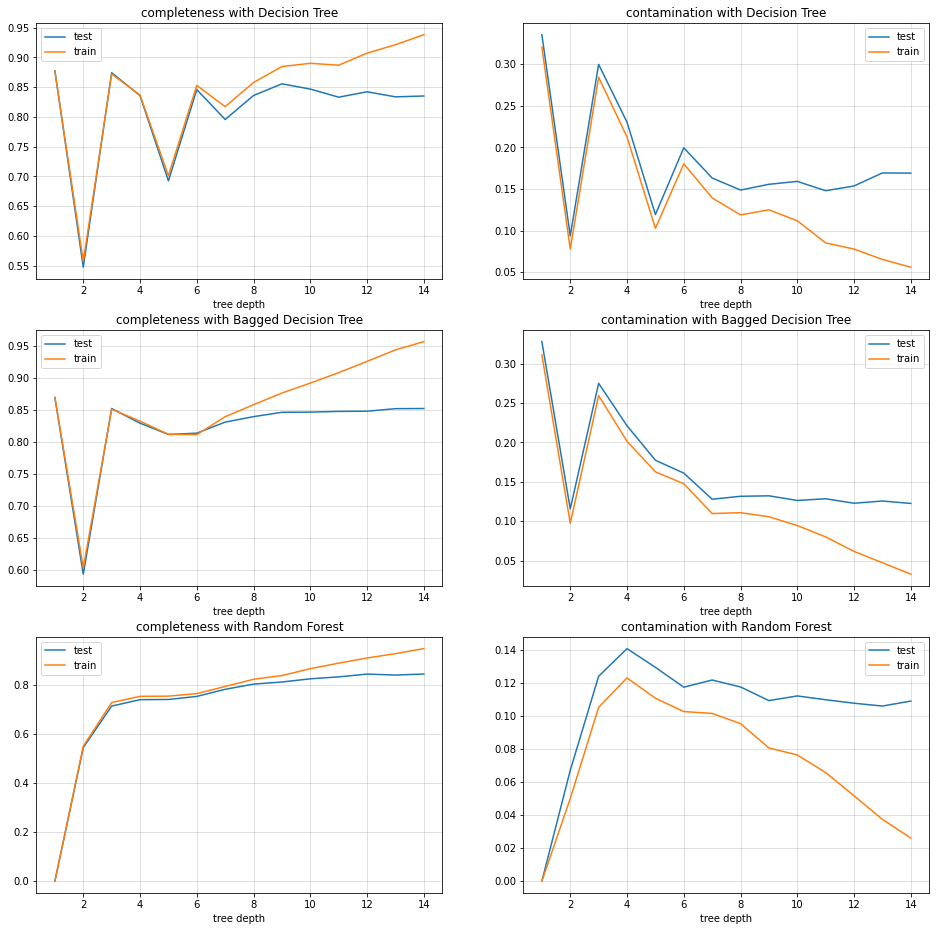

In [34]:
completeness_dt_test, contamination_dt_test = completeness_contamination(det_pred_dt_test, det_test)
completeness_dt_train, contamination_dt_train = completeness_contamination(det_pred_dt_train, det_train)

completeness_bdt_test, contamination_bdt_test = completeness_contamination(det_pred_bdt_test, det_test)
completeness_bdt_train, contamination_bdt_train = completeness_contamination(det_pred_bdt_train, det_train)

completeness_rf_test, contamination_rf_test = completeness_contamination(det_pred_rf_test, det_test)
completeness_rf_train, contamination_rf_train = completeness_contamination(det_pred_rf_train, det_train)

fig, axs = plt.subplots(3,2, figsize = (16,16))

axs[0,0].plot(d, completeness_dt_test, label = 'test')
axs[0,0].plot(d, completeness_dt_train, label = 'train')
axs[0,0].set_title('completeness with Decision Tree')
axs[0,0].set_xlabel('tree depth')

axs[1,0].plot(d, completeness_bdt_test, label = 'test')
axs[1,0].plot(d, completeness_bdt_train, label = 'train')
axs[1,0].set_title('completeness with Bagged Decision Tree')
axs[1,0].set_xlabel('tree depth')

axs[2,0].plot(d, completeness_rf_test, label = 'test')
axs[2,0].plot(d, completeness_rf_train, label = 'train')
axs[2,0].set_title('completeness with Random Forest')
axs[2,0].set_xlabel('tree depth')


axs[0,1].plot(d, contamination_dt_test, label = 'test')
axs[0,1].plot(d, contamination_dt_train, label = 'train')
axs[0,1].set_title('contamination with Decision Tree')
axs[0,1].set_xlabel('tree depth')

axs[1,1].plot(d, contamination_bdt_test, label = 'test')
axs[1,1].plot(d, contamination_bdt_train, label = 'train')
axs[1,1].set_title('contamination with Bagged Decision Tree')
axs[1,1].set_xlabel('tree depth')

axs[2,1].plot(d, contamination_rf_test, label = 'test')
axs[2,1].plot(d, contamination_rf_train, label = 'train')
axs[2,1].set_title('contamination with Random Forest')
axs[2,1].set_xlabel('tree depth')

for i in range(3):
    for j in range(2):
        axs[i,j].grid(alpha = 0.5)
        axs[i,j].legend()

In [35]:
# search for the best depth of tree
estimator = DecisionTreeClassifier(max_depth = d, random_state=2002, criterion = 'entropy')

search = GridSearchCV(estimator, param_grid = {'max_depth': d}, cv = 5)
search.fit(data_train, det_train)
best_depth = search.best_params_['max_depth']
print("best depth = " + str(best_depth))

best depth = 8


Completeness: DT =  0.8360795454545454  | BDT =  0.8397727272727272  | RF =  0.8073863636363636
Contamination: DT =  0.1486838299103269  | BDT =  0.13160987074030553  | RF =  0.11903285802851829


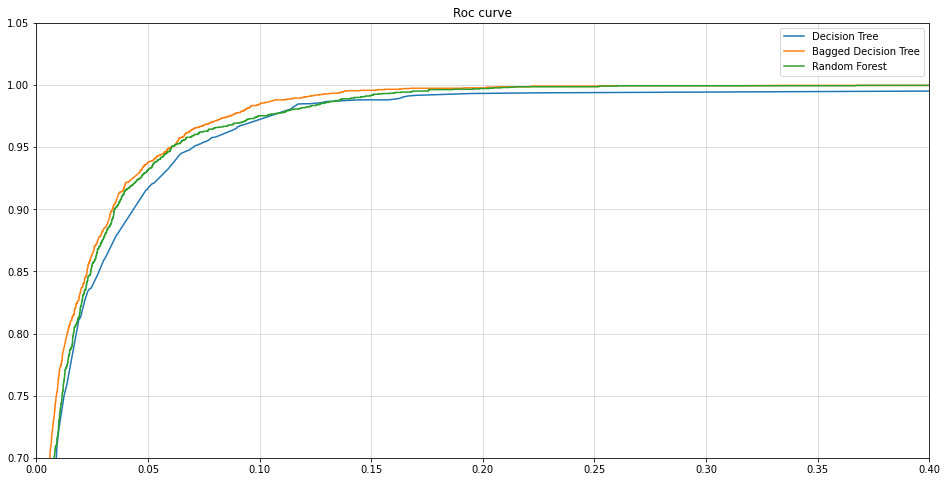

In [36]:
dt = DecisionTreeClassifier(max_depth = best_depth, random_state=2002, criterion = 'entropy')
bdt = BaggingClassifier(dt, random_state=2002, n_jobs=-1)
rf = RandomForestClassifier(max_depth = best_depth)

dt.fit(data_train, det_train)
bdt.fit(data_train, det_train)
rf.fit(data_train, det_train)

det_prob_dt = dt.predict_proba(data_test)[:,1]
det_prob_bdt = bdt.predict_proba(data_test)[:,1]
det_prob_rf = rf.predict_proba(data_test)[:,1]

det_pred_dt = dt.predict(data_test)
det_pred_bdt = bdt.predict(data_test)
det_pred_rf = rf.predict(data_test)

def comp_cont(test, pred):
    C = confusion_matrix(test, pred)
    tn, fp, fn, tp = C.ravel()
    comp = tp/(tp+fn)
    cont = fp/(tp+fp)
    return comp, cont

fpr_dt, tpr_dt, thresholds_dt = roc_curve(det_test, det_prob_dt)
comp_dt, cont_dt = comp_cont(det_test, det_pred_dt)
fpr_bdt, tpr_bdt, thresholds_bdt = roc_curve(det_test, det_prob_bdt)
comp_bdt, cont_bdt = comp_cont(det_test, det_pred_bdt)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(det_test, det_prob_rf)
comp_rf, cont_rf = comp_cont(det_test, det_pred_rf)

fig = plt.figure(figsize = (16,8))
plt.grid(alpha=0.5)
plt.plot(fpr_dt, tpr_dt, label = 'Decision Tree')
plt.plot(fpr_bdt, tpr_bdt, label = 'Bagged Decision Tree')
plt.plot(fpr_rf, tpr_rf, label = 'Random Forest')
plt.title('Roc curve')
plt.ylim(0.7, 1.05)
plt.xlim(0, 0.4)
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.legend()

print('Completeness: DT = ',comp_dt ,' | BDT = ',comp_bdt ,' | RF = ',comp_rf )
print('Contamination: DT = ',cont_dt ,' | BDT = ',cont_bdt ,' | RF = ',cont_rf )

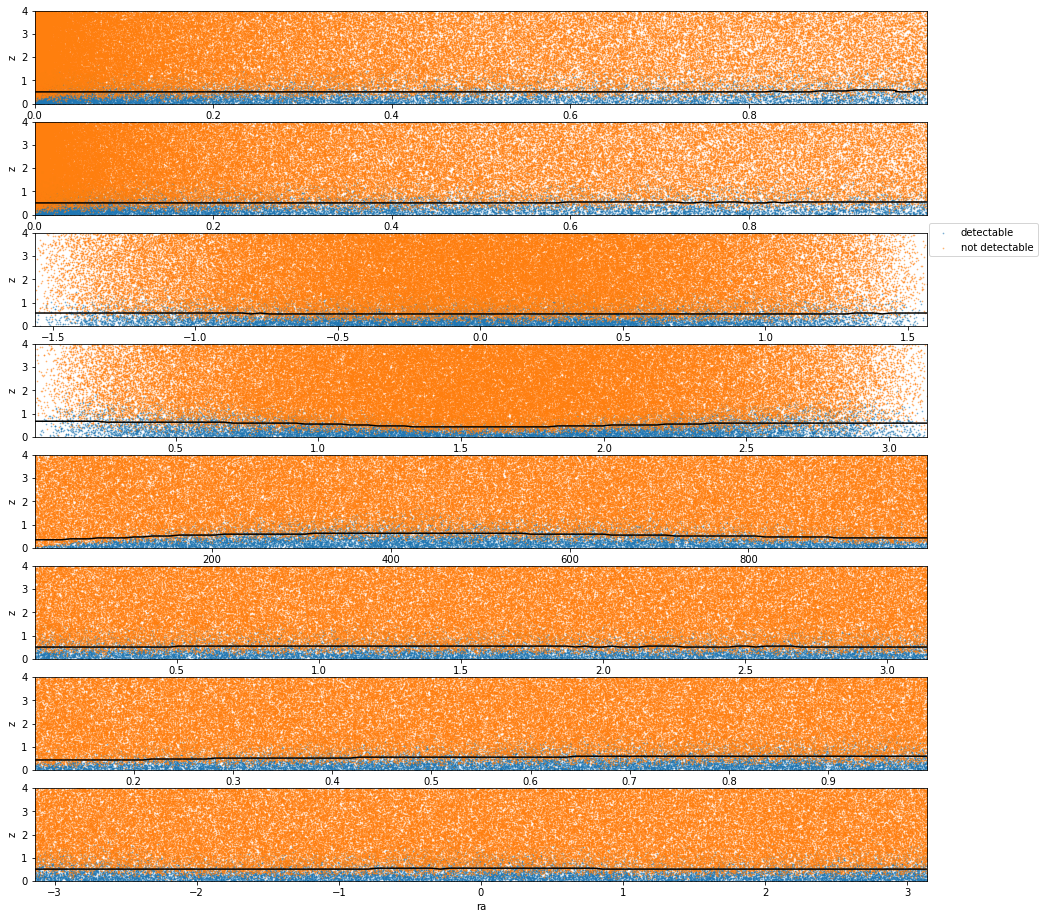

In [37]:
#plot all the variables vs z and compute with BaggingClassifier the boundary between detect/non_detect

filter = (features['snr'] > 12)

fig, axs = plt.subplots(8, figsize = (16,16))


for i in range(len(axs)):
    
    train = data_train[:,[i,8]]
    test = data_test[:,[i,8]]
    #Decision Tree
    clf = BaggingClassifier(
    DecisionTreeClassifier(max_depth = best_depth, random_state=2002), 
    n_estimators=500, max_samples=100, 
    bootstrap=True, random_state=2002, n_jobs=-1)
    clf.fit(train, det_train)

    xlim = (data.iloc[:, i].min(), data.iloc[:, i].max())
    ylim = (0, 4)

    x, y = np.meshgrid(np.linspace(xlim[0], xlim[1], 100),
                     np.linspace(ylim[0], ylim[1], 100))
    xystack = np.vstack([x.ravel(),y.ravel()])
    Xgrid = xystack.T

    db = clf.predict(Xgrid)
    db = db.reshape(x.shape)
    
    axs[i].scatter(data.iloc[:, i][filter], features['z'][filter], s = 0.5, alpha = 0.5, label = 'detectable')
    axs[i].scatter(data.iloc[:, i][~filter], features['z'][~filter], s = 0.5, alpha = 0.5, label = 'not detectable') 
    axs[i].set_xlabel(list(data.columns)[i])
    axs[i].set_ylabel('z')
    axs[i].set_xlim(data.iloc[:, i].min(), data.iloc[:, i].max())
    axs[i].set_ylim(0,4)
    axs[i].contour(x, y, db, [0.5], colors='k')


lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes[:1]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, bbox_to_anchor=(1, 0.7))

In [54]:
### classification with multilayer perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
feature_scaled = scaler.fit_transform(features)

(x_train, x_test), (det_train, det_test)= split_samples(feature_scaled, det, [0.75, 0.25],
                                                     random_state=0)

In [55]:
mlp = MLPClassifier(max_iter=500, solver = 'adam', alpha = 0.0001, learning_rate = 'constant', learning_rate_init = 0.0001)
parameters = {'hidden_layer_sizes': np.arange(5, 30), 'activation': ['tanh', 'relu']}


In [56]:
#kfold cv for best parameters search
gdscv = GridSearchCV(mlp, parameters, n_jobs=-1, cv=5)
gdscv.fit(x_train, det_train)

/home/sara/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/sara/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/sara/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/sara/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/sara/.local/lib/python3.9/site-packages/sklearn/neural

GridSearchCV(cv=5,
             estimator=MLPClassifier(learning_rate_init=0.0001, max_iter=500),
             n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'hidden_layer_sizes': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29])})

In [67]:
print(gdscv.best_params_)
bestmlp = gdscv.best_estimator_
bestmlp.fit(x_train, det_train)
det_proba=bestmlp.predict_proba(x_test)[:,1]
det_pred = bestmlp.predict(x_test)

{'activation': 'tanh', 'hidden_layer_sizes': 27}


Completeness =  0.9693181818181819  | Contamination =  0.01756406564929456


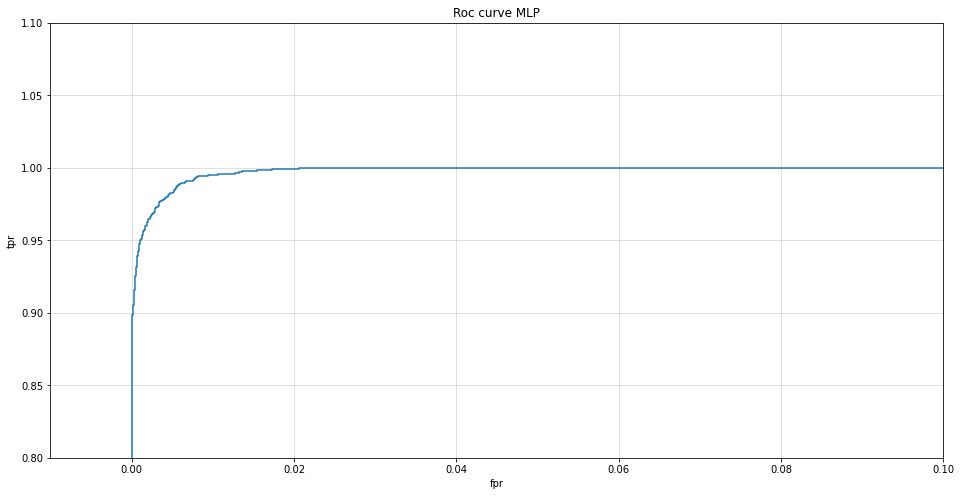

In [74]:
fpr, tpr, threshold = roc_curve(det_test, det_proba)
completeness, contamination = comp_cont(det_test, det_pred)
fig = plt.figure(figsize = (16,8))
plt.grid(alpha=0.5)
plt.xlim(-0.01, 0.1)
plt.ylim(0.8, 1.1)
plt.plot(fpr, tpr)
plt.title('Roc curve MLP')
plt.xlabel('fpr')
plt.ylabel('tpr')
print("Completeness = ", completeness, " | Contamination = ", contamination)